In [1]:
%mkdir ../data
!wget -O ../data/all_tickets.csv https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv

The syntax of the command is incorrect.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import numpy as np
import pandas as pd
import os

data = pd.read_csv(os.path.abspath(os.getcwd()) + "\\data\\all_tickets.csv").drop(["title", "ticket_type", "sub_category1", "sub_category2", "business_service", "urgency", "impact"],axis=1)
data.head()

,body,category
0,hi since recruiter lead permission approve req...,4
1,icon dear please setup icon per icon engineers...,6
2,work experience user hi work experience studen...,5
3,requesting meeting hi please help follow equip...,5
4,re expire days hi ask help update passwords co...,4


(0, 10000)

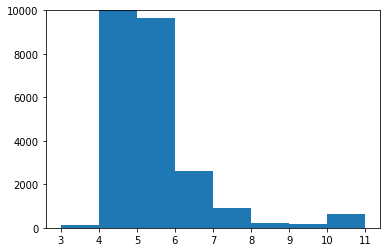

In [249]:
import matplotlib.pyplot as plt

plt.hist(df["category"], bins=len(set(df["category"])))
plt.ylim((0,10000))

In [2]:
df = data[data.groupby("category")['category'].transform('count') > 100]
df.shape

(48423, 2)

In [3]:
from sklearn.utils import shuffle

df = shuffle(df)
df = df.reset_index()

In [4]:
df.groupby("category")["category"].value_counts()

category  category
3         3             137
4         4           34061
5         5            9634
6         6            2628
7         7             921
8         8             239
9         9             191
11        11            612
Name: category, dtype: int64

In [5]:
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


cache_dir = os.path.join("\Data")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

stopwords_set = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
le = LabelEncoder()

with open(os.path.join(cache_dir, "transformer.pkl"), "rb") as f:
                cache_data = pickle.dump(dict(stopwords = stopwords_set, lemmatizer = lemmatizer, encoder = le), f)

def word_processor(requests):
    text = re.sub(r"[^a-zA-Z0-9]", " ", requests.lower())
    tokens = word_tokenize(text)
    result = []
    for word in tokens:
        lemmatized_word = lemmatizer.lemmatize(word)
        if lemmatized_word not in stopwords_set:
                result.append(lemmatized_word)
    return result
            
def prepare_data(raw_data, vocab_fraction, cache_file="preprocessed_data.pkl"):
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass
    
    if cache_data = None:
        agg_docs = raw_data.groupby("category")["body"].apply(lambda x: " ".join(x)).reset_index()
        vocab_dict = {}
        vocab = []
        for idx, doc in agg_docs.iterrows():
            tokens = word_processor(doc["body"])
            counts = Counter([t for t in tokens if not t in stopwords_set])
            sorted_words = list({k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}.keys())
            vocab.extend(sorted_words[:int(vocab_fraction*len(sorted_words))+1])
            vocab_dict[str(doc["category"])] = sorted_words[:int(vocab_fraction*len(sorted_words))+1]
        vocab = list(set(vocab))

        vectorizer = TfidfVectorizer(analyzer='word', 
                                     vocabulary=list(set(vocab)), 
                                     lowercase=True, use_idf=True, 
                                     stop_words='english')

        X = vectorizer.fit_transform(df["body"])  
        X = X.todense()
        labels = le.fit_transform(raw_data["category"].astype("str").to_list())
        
        with open(os.path.join(cache_dir, "transformer.pkl"), "rb") as f:
                cache_data = pickle.dump(dict(stopwords = stopwords_set, lemmatizer = lemmatizer, 
                                              encoder = le, vectorizer = vectorizer), f)
        
        if cache_file is not None:
            cache_data = dict(X=X, labels=labels,
                              vocab_dict=vocab_dict, vocab=vocab)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
         # Unpack data loaded from cache file
        X, labels, vocab_dict, vocab = (cache_data['X'],
                cache_data['labels'], cache_data['vocab_dict'], cache_data['vocab'])
    
    
    return X, labels, vocab_dict, vocab

In [6]:
X, labels, vocab_dict, vocab = prepare_data(df, 0.4)

([<matplotlib.axis.YTick at 0x1ea7642a9e8>,
 <a list of 8 Text yticklabel objects>)

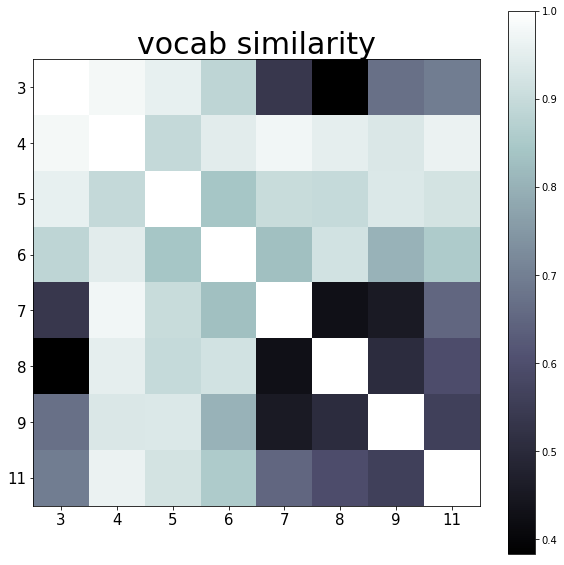

In [26]:
import matplotlib.pyplot as plt

comm_mat = np.zeros((8,8))
for idx, cat1 in enumerate(vocab_dict.keys()):
    for idy, cat2 in enumerate(vocab_dict.keys()):
         comm_mat[idx,idy] = len(set(vocab_dict[cat1]) & set(vocab_dict[cat2]))/min([len(vocab_dict[cat1]), len(vocab_dict[cat2])])
    
    
plt.figure(figsize=(10,10))
plt.imshow(comm_mat, interpolation='nearest', cmap=plt.cm.bone)
plt.title("vocab similarity", fontsize=30)
plt.colorbar()
tick_marks = np.arange(len(set(labels)))
plt.xticks(tick_marks, vocab_dict.keys(), fontsize=15)
plt.yticks(tick_marks, vocab_dict.keys(), fontsize=15)


In [27]:
input_data = pd.concat([pd.DataFrame(X), pd.DataFrame(labels)], axis = 1)

In [42]:

from collections import deque
from itertools import islice

def make_samples(data, n_sample, maj_cat, cut_off):
    samples = []
    
    fixed_idx = list(data[~data.iloc[:,-1].isin(maj_cat)].index)
    maj_idx = []
    for  cat in maj_cat:
        maj_idx.append(deque(data[data.iloc[:,-1] == cat].index, 
                               maxlen = len(data[data.iloc[:,-1] == cat])))
    

    for s in range(n_sample):
        var_idx = []
        for i, cat in enumerate(maj_idx):
            var_idx.extend(list(islice(cat,0,cut_off)))
            maj_idx[i].rotate(cut_off-1)
        composite_idx = var_idx + fixed_idx
        samples.append(data.iloc[composite_idx, :])
    
    return samples
    

In [47]:
samples = make_samples(input_data,7,[4, 5],5000)

In [56]:
#save samples
from sklearn.model_selection import train_test_split
for i in range(3):
    train, test = train_test_split(shuffle(samples[i]), test_size = 0.2)
    train.to_csv(os.getcwd()+"\\data\\train{}.csv".format(str(i+1)),  header=False, index=False)
    test.to_csv(os.getcwd()+"\\data\\test{}.csv".format(str(i+1)),  header=False, index=False)
    

KeyboardInterrupt: 

In [54]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/capstone_project'

role = sagemaker.get_execution_role()

prefix = 'capstone_project'

val_location = session.upload_data(os.path.join(data_dir, 'test1.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train1.csv'), key_prefix=prefix)

'D:\\Trainning\\UdacityMLEngineer\\Capestone Projectsmth1.txt'

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p4.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'train_set': "train1.csv",
                    })

In [ ]:
estimator.fit({'training': input_data})

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [ ]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)